Manga Faces Mood Classifier

Dataset: https://www.kaggle.com/datasets/mertkkl/manga-facial-expressions

References: 

1.   [ \[Pytorch\] - Manga Facial Expression Classificationt](https://www.kaggle.com/code/mertkkl/pytorch-manga-facial-expression-classification/)
2.   [POZZ (MAIS Hacks submission)](https://github.com/amnbot/POZZ/blob/master/jupyter/model.ipynb)


**To look at:**

https://stackoverflow.com/questions/61858768/why-is-the-accuracy-of-my-pretrained-resnet-152-model-so-low


In [29]:
# Imports

import torchvision
import torchvision.datasets as datasets # For importing dataset
import torchvision.models as models # For ResNet-50

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import numpy as np


In [30]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # Device to send data and model to

In [31]:
from PIL import Image, ImageEnhance
# transform class to make images sharper
class Sharpie(object):
    def __init__(self,factor):
        self.factor = factor

    def __call__(self, x):
        enhancer = ImageEnhance.Sharpness(x)
        img = enhancer.enhance(self.factor)
        return img

**From PyTorch [documentation](https://pytorch.org/hub/pytorch_vision_resnet/):**

"All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]."

In [32]:
# Image preprocessing
from torchvision import transforms

factor = 2

# Original images
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = factor),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

# Horizontally flipped images
preprocess2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.RandomHorizontalFlip(1),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = factor),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

# Rotated 45 to 90
preprocess3 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.RandomRotation([45, 75]),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = factor),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

# Rotated -90 to -45
preprocess4 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.RandomRotation([-75,-45]),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = factor),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

# Rotated 45 to 90 + flipped
preprocess5 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomRotation([45, 75]),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = factor),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

# Rotated -90 to -45 + flipped
preprocess6 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(3),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomRotation([-75,-45]),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_contrast(x, 2)),
    transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_gamma(x, 2)),
    Sharpie(factor = factor),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # These values seem to be a sort of "convention" (found in docs and other projects)
])

In [33]:
# Load the dataset
dataset_ori = datasets.ImageFolder('manga-faces', transform=preprocess)
dataset_hf = datasets.ImageFolder('manga-faces', transform=preprocess2)
dataset_pr = datasets.ImageFolder('manga-faces', transform=preprocess3)
dataset_nr = datasets.ImageFolder('manga-faces', transform=preprocess4)
dataset_hf_pr = datasets.ImageFolder('manga-faces', transform=preprocess5)
dataset_hf_nr = datasets.ImageFolder('manga-faces', transform=preprocess6)
dataset = torch.utils.data.ConcatDataset([dataset_ori, dataset_hf, dataset_pr, dataset_nr, dataset_hf_pr, dataset_hf_nr])
# dataset = torch.utils.data.ConcatDataset([dataset_ori, dataset_hf])
print(len(dataset))
dataset_size = len(dataset)

4080


In [34]:
# Split the dataset into training and testing dataset
# Using a 80 % of data for training and 20 % for training
train_size = int(0.9 * dataset_size)
num_display_images = 5
test_size = dataset_size - train_size - num_display_images
train_ds, test_ds, display_imgs = data.random_split(dataset, [train_size, test_size, num_display_images])

In [35]:
train_loader = data.DataLoader(train_ds, shuffle=True, batch_size=15)
test_loader = data.DataLoader(test_ds, shuffle=True, batch_size=10)
display_loader = data.DataLoader(display_imgs, shuffle=True, batch_size=num_display_images)

[Visualizing a grid of images](https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#sphx-glr-auto-examples-plot-visualization-utils-py)

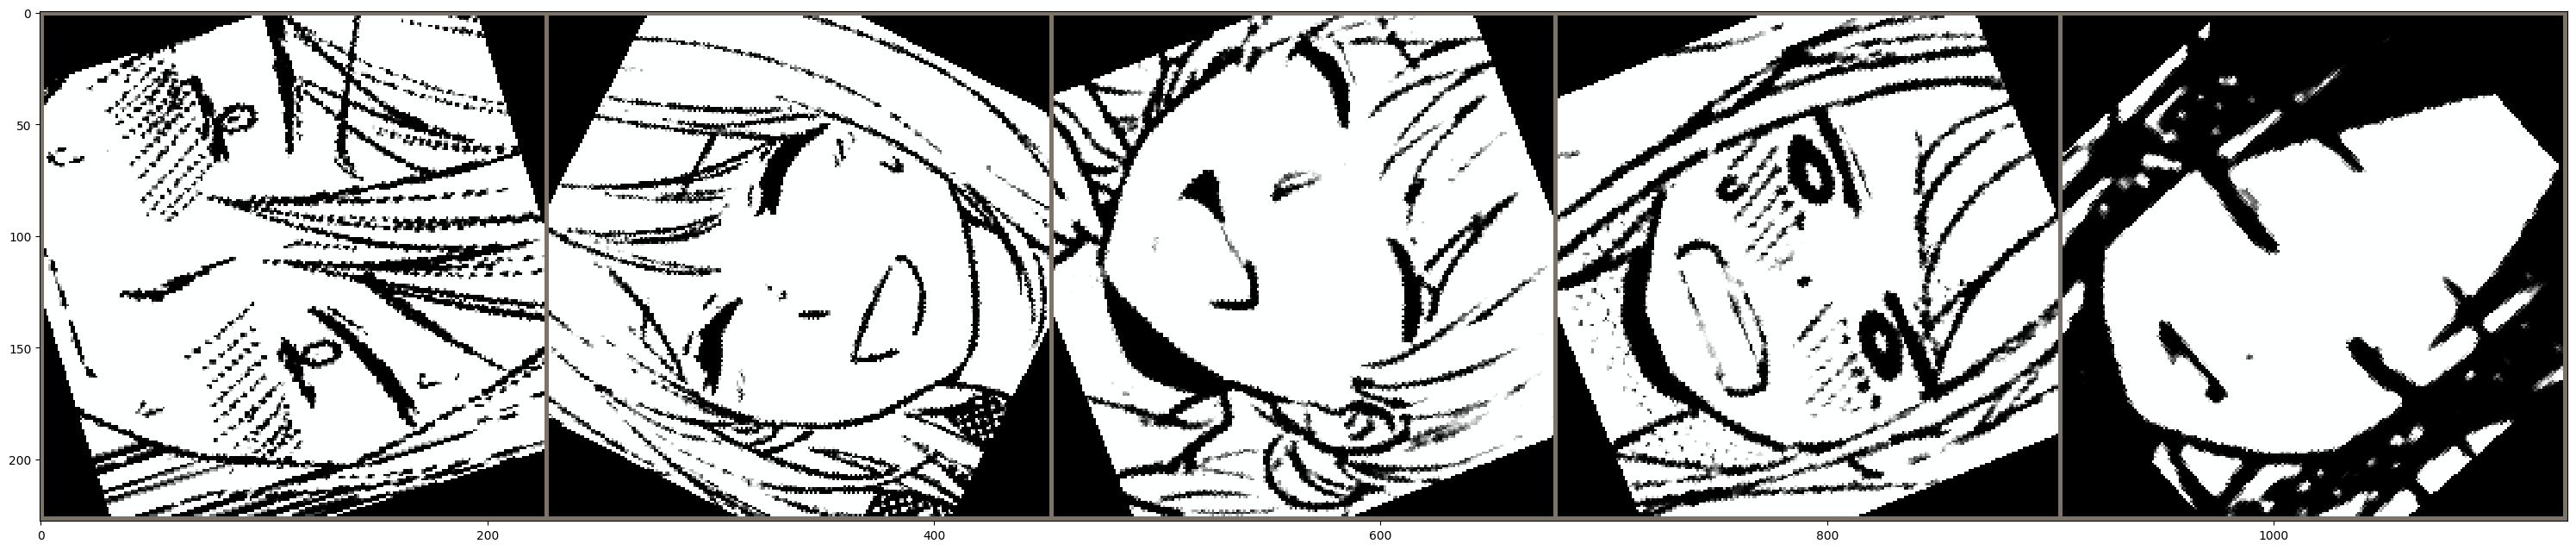

In [36]:
# Display the images (for preprocessing)
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms.functional as Func

def show(imgs):
  ax = plt.subplots(figsize = (30, 90))
  inp = imgs.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp, interpolation='nearest')

inputs, labels = next(iter(display_loader))
# idx_to_class = {v: k for k, v in display_loader.dataset.dataset.class_to_idx.items()}
# display_moods = []
# for label in labels:
#   display_moods.append(idx_to_class[int(label)])
# print(display_moods)
grid = make_grid(inputs)
show(grid)

**From PyTorch [documentation](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)**

"By default, when we load a pretrained model all of the parameters have .requires_grad=True, which is fine if we are training from scratch or finetuning. However, if we are feature extracting and only want to compute gradients for the newly initialized layer then we want all of the other parameters to not require gradients. This will make more sense later."

In [37]:
criter = nn.CrossEntropyLoss()
model = models.resnet50(pretrained=True)

# Replace the last fully-connected (fc) layer since we only have 7 classes
for param in model.parameters():
    param.requires_grad  = False

in_feats = model.fc.in_features
num_classes = 7
model.fc = nn.Linear(in_feats, num_classes)
model = model.to(device) # Move model to device

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [38]:
# Training function (training done twice, once for the last layer, and another time for the entire model)

def train_model(model, epoch, loss_lst):
  model.train()
  running_loss = 0

  for batch, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device) # Move data to device
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criter(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*inputs.size(0)

    if (batch % 20 == 0):
      print(f'Epoch: {epoch} \t Loss: {loss}')
  
  running_loss /= len(train_loader.dataset)
  loss_lst.append(running_loss)
  print(f'Average loss: {running_loss}')

In [39]:
# Train last layer

num_epochs_last_layer = 75
print('Training last layer...')
train_loss = []
for epoch in range(1, num_epochs_last_layer + 1):
  train_model(model, epoch, train_loss)

Training last layer...
Epoch: 1 	 Loss: 1.9733637571334839
Epoch: 1 	 Loss: 1.7188868522644043
Epoch: 1 	 Loss: 1.6412179470062256
Epoch: 1 	 Loss: 1.8064038753509521
Epoch: 1 	 Loss: 1.6786048412322998
Epoch: 1 	 Loss: 1.7095478773117065
Epoch: 1 	 Loss: 1.4279100894927979
Epoch: 1 	 Loss: 1.8068697452545166
Epoch: 1 	 Loss: 1.2617039680480957
Epoch: 1 	 Loss: 1.9617329835891724
Epoch: 1 	 Loss: 1.7573434114456177
Epoch: 1 	 Loss: 1.2495367527008057
Epoch: 1 	 Loss: 1.3897346258163452
Average loss: 1.6948605735901914
Epoch: 2 	 Loss: 1.036611557006836
Epoch: 2 	 Loss: 0.9364576935768127
Epoch: 2 	 Loss: 1.6479233503341675
Epoch: 2 	 Loss: 1.3503222465515137
Epoch: 2 	 Loss: 1.7330060005187988
Epoch: 2 	 Loss: 1.4345829486846924
Epoch: 2 	 Loss: 1.4711956977844238
Epoch: 2 	 Loss: 1.7417384386062622
Epoch: 2 	 Loss: 1.2455902099609375
Epoch: 2 	 Loss: 1.2977832555770874
Epoch: 2 	 Loss: 1.3687117099761963
Epoch: 2 	 Loss: 1.3393393754959106
Epoch: 2 	 Loss: 1.199169397354126
Average lo

[1.822738024241784, 1.4415100324972003, 1.30935680442581, 1.2051349096730644, 1.0961186539600878, 1.066565353496402, 0.9815228910130613, 0.9782210603064182, 0.9380170286578291, 0.8889079979237389, 0.8512506765477797, 0.8629615852499709, 0.7873321655480301, 0.8094237877749929, 0.7874764730679054, 0.8024180402942732, 0.7357332430341664, 0.7084847628047654, 0.722013625005881, 0.6939417529193794, 0.6531661651736381, 0.660389663688108, 0.6679546604407769, 0.6343981166753698, 0.6282023440169937, 0.6396346840569201, 0.6339020805031645, 0.6696505913255262, 0.5742090503301691, 0.655483712022211, 0.6279293228232977, 0.5977976561396146, 0.5725236279415149, 0.5466255541963905, 0.5042295528977525, 0.5405761491799471, 0.539698669321689, 0.5031078920571828, 0.5386728331373603, 0.5865409804836792, 0.49971597404310514, 0.5503844438741604, 0.5026261476325053, 0.47988876455700863, 0.48093671125232007, 0.5063754351919189, 0.5556197872421905, 0.46257078004818336, 0.48288522080025253, 0.4737350492208612, 0.

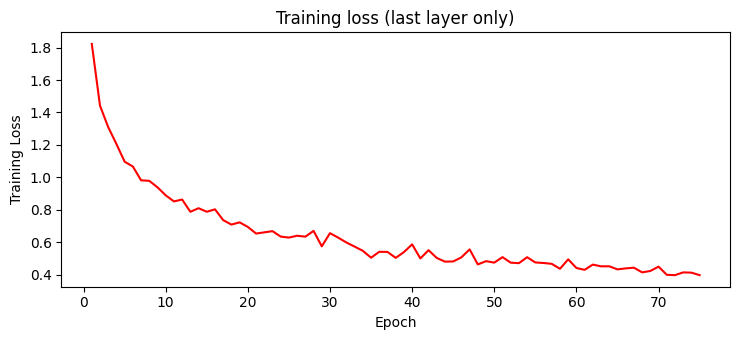

In [ ]:
print(train_loss)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training loss (last layer only)")
plt.plot(range(1, len(train_loss) + 1), train_loss, color="red")
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.show()

From [docs](https://pytorch.org/docs/stable/generated/torch.argmax.html):



```
>>> a = torch.randn(4, 4)
>>> a
tensor([[ 1.3398,  0.2663, -0.2686,  0.2450],
        [-0.7401, -0.8805, -0.3402, -1.1936],
        [ 0.4907, -1.3948, -1.0691, -0.3132],
        [-1.6092,  0.5419, -0.2993,  0.3195]])
>>> torch.argmax(a, dim=1)
tensor([ 0,  2,  0,  1])
```



In [ ]:
# Testing function

def test_model(model, loader, accuracy):
  total = 0
  correct = 0
  preds = []
  targets = []

  model.eval()
  with torch.no_grad():
    
    for batch, (inputs, labels) in enumerate(loader):
      inputs, labels = inputs.to(device), labels.to(device) # Move data to device

      outputs = model(inputs)
      # Use dim=1 to keep an array of the indices of the max values for each output
      pred = outputs.argmax(dim = 1, keepdim = False)
      for p in pred:
        preds.append(int(p))
      for l in labels:
        targets.append(int(l))
      res = torch.eq(pred, labels)
      for r in res:
        total += 1
        if r == True:
          correct += 1
      accuracy.append(correct / total)
      if (batch % 5 == 0):
        print(f'Accuracy: {correct} / {total} ({round((correct / total), 2)} %)')
    return torch.as_tensor(preds), torch.as_tensor(targets)

In [ ]:
from torchmetrics import ConfusionMatrix
# Training accuracy for last layer
training_accuracy = []
preds, targets = test_model(model, train_loader, training_accuracy)
confmat = ConfusionMatrix(num_classes=7)
confmat(preds, targets)

Accuracy: 14 / 15 (0.93 %)
Accuracy: 88 / 90 (0.98 %)
Accuracy: 160 / 165 (0.97 %)
Accuracy: 235 / 240 (0.98 %)
Accuracy: 308 / 315 (0.98 %)
Accuracy: 381 / 390 (0.98 %)
Accuracy: 455 / 465 (0.98 %)
Accuracy: 528 / 540 (0.98 %)
Accuracy: 603 / 615 (0.98 %)
Accuracy: 678 / 690 (0.98 %)
Accuracy: 751 / 765 (0.98 %)
Accuracy: 825 / 840 (0.98 %)
Accuracy: 897 / 915 (0.98 %)
Accuracy: 970 / 990 (0.98 %)
Accuracy: 1043 / 1065 (0.98 %)
Accuracy: 1115 / 1140 (0.98 %)
Accuracy: 1190 / 1215 (0.98 %)


tensor([[146,   1,   0,   0,   0,   0,   4],
        [  0, 146,   0,   0,   0,   0,   0],
        [  1,   1, 160,   0,   0,   0,   1],
        [  5,   3,   1, 241,   2,   0,   3],
        [  0,   0,   0,   1, 148,   0,   1],
        [  0,   1,   0,   0,   0, 146,   1],
        [  0,   0,   0,   0,   0,   0, 211]])

In [ ]:
from torchmetrics.functional import precision_recall
precision_recall(preds, targets, average='micro', num_classes=7)

(tensor(0.9788), tensor(0.9788))

In [ ]:
# Testing accuracy for last layer
testing_accuracy = []
preds, targets = test_model(model, test_loader, testing_accuracy)
confmat = ConfusionMatrix(num_classes=7)
confmat(preds, targets)

Accuracy: 7 / 10 (0.7 %)
Accuracy: 43 / 60 (0.72 %)
Accuracy: 83 / 110 (0.75 %)


tensor([[12,  0,  3,  0,  2,  0,  2],
        [ 0, 10,  3,  0,  0,  1,  1],
        [ 1,  0, 16,  1,  1,  1,  1],
        [ 1,  2,  3, 22,  0,  0,  1],
        [ 1,  0,  0,  1,  6,  1,  1],
        [ 0,  0,  0,  0,  0, 13,  1],
        [ 1,  0,  1,  1,  0,  0, 20]])

In [ ]:
precision_recall(preds, targets, average='micro', num_classes=7)

(tensor(0.7557), tensor(0.7557))

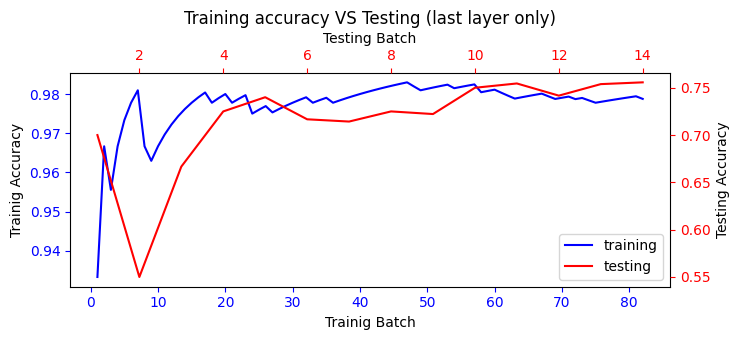

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, label="training")
ax2 = fig.add_subplot(111, label="testing", frame_on=False)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training accuracy VS Testing (last layer only)")

ax.plot(range(1, len(training_accuracy) + 1), training_accuracy, color="blue", label="training")
ax.set_xlabel("Trainig Batch")
ax.set_ylabel("Trainig Accuracy")
ax.tick_params(axis='x', colors="blue")
ax.tick_params(axis='y', colors="blue")

ax2.plot(range(1, len(testing_accuracy) + 1), testing_accuracy, color="red", label="testing")
ax2.set_xlabel("Testing Batch")
ax2.set_ylabel("Testing Accuracy")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="red")
ax2.tick_params(axis='y', colors="red")

handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc="lower right")
plt.show()

In [ ]:
# Set requires_grad = True for the layer
for param in model.parameters():
  param.requires_grad = True

# Train entire model
num_epochs_entire_model = 75
model_train_loss = []
print('Training entire model...')
for epoch in range(1, num_epochs_entire_model + 1):
  train_model(model, epoch, model_train_loss)

Training entire model...
Epoch: 1 	 Loss: 0.3102658689022064
Epoch: 1 	 Loss: 2.5627939701080322
Epoch: 1 	 Loss: 2.141526460647583
Epoch: 1 	 Loss: 1.6917405128479004
Epoch: 1 	 Loss: 1.606107473373413
Average loss: 2.4355555604047634
Epoch: 2 	 Loss: 1.7028160095214844
Epoch: 2 	 Loss: 1.3573251962661743
Epoch: 2 	 Loss: 1.1127498149871826
Epoch: 2 	 Loss: 0.7690505385398865
Epoch: 2 	 Loss: 0.9349161386489868
Average loss: 1.1587854257109118
Epoch: 3 	 Loss: 0.4691337049007416
Epoch: 3 	 Loss: 0.2564128339290619
Epoch: 3 	 Loss: 0.2218349725008011
Epoch: 3 	 Loss: 0.7898836135864258
Epoch: 3 	 Loss: 0.42347803711891174
Average loss: 0.7776519732513264
Epoch: 4 	 Loss: 0.3856981098651886
Epoch: 4 	 Loss: 0.34648221731185913
Epoch: 4 	 Loss: 0.3591359853744507
Epoch: 4 	 Loss: 0.6475748419761658
Epoch: 4 	 Loss: 0.06660566478967667
Average loss: 0.5812332986616621
Epoch: 5 	 Loss: 0.3462366759777069
Epoch: 5 	 Loss: 0.3238317370414734
Epoch: 5 	 Loss: 0.0572330467402935
Epoch: 5 	 Los

[2.4355555604047634, 1.1587854257109118, 0.7776519732513264, 0.5812332986616621, 0.4274256718436293, 0.3593324831705175, 0.18769330580207502, 0.26368843812915477, 0.30418102357846993, 0.24171196976585277, 0.16151845861938507, 0.15754075175808632, 0.11086924724604971, 0.07616915111372922, 0.19174043620438955, 0.32359530928307306, 0.2740571292062454, 0.15860743574597233, 0.10620880440817963, 0.24761313906249902, 0.26379985837539766, 0.12670493800667862, 0.1279835915033176, 0.1034393314096401, 0.21975387276752906, 0.2138809583186373, 0.2502093016827369, 0.1592115856702531, 0.20334017934624618, 0.12325959260274164, 0.1881605837124345, 0.12493134379459947, 0.21950909583007588, 0.29584020585753024, 0.1409368557974185, 0.07216475176021192, 0.13347610867326604, 0.15130212077615307, 0.3061960548637252, 0.18930652266021306, 0.14751820809061766, 0.15954282510496093, 0.10672740248264745, 0.09361878192102463, 0.18178816189574004, 0.1454191656495609, 0.12903827772585347, 0.20157051842782975, 0.16175

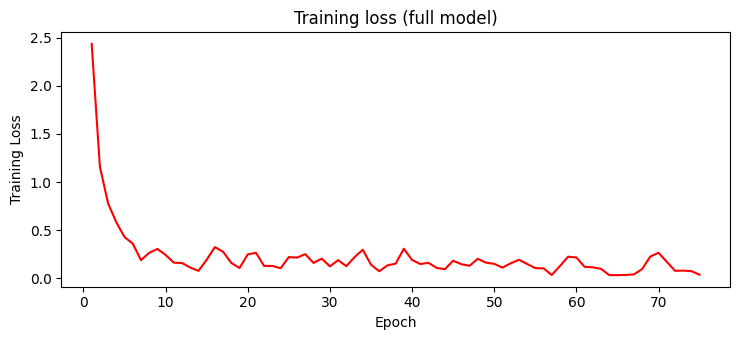

In [ ]:
print(model_train_loss)

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training loss (full model)")
plt.plot(range(1, len(model_train_loss) + 1), model_train_loss, color="red")
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.show()

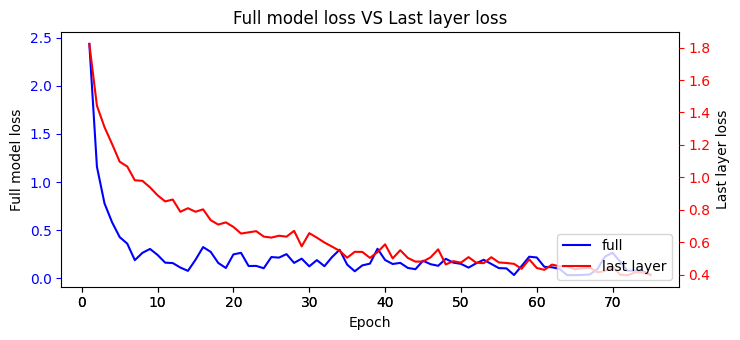

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, label="training")
ax2 = fig.add_subplot(111, label="testing", frame_on=False)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Full model loss VS Last layer loss")


ax.plot(range(1, len(model_train_loss) + 1), model_train_loss, color="blue", label="full")
ax.set_ylabel("Full model loss")
ax.tick_params(axis='y', colors="blue")

ax2.plot(range(1, len(train_loss) + 1), train_loss, color="red", label="last layer")
ax2.set_ylabel("Last layer loss")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', colors="red")

plt.xlabel('Epoch')
handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc="lower right")
plt.show()

In [ ]:
# Training accuracy for entire model
model_training_accuracy = []
preds, targets = test_model(model, train_loader, model_training_accuracy)
confmat = ConfusionMatrix(num_classes=7)
confmat(preds, targets)

Accuracy: 15 / 15 (1.0 %)
Accuracy: 90 / 90 (1.0 %)
Accuracy: 165 / 165 (1.0 %)
Accuracy: 240 / 240 (1.0 %)
Accuracy: 315 / 315 (1.0 %)
Accuracy: 390 / 390 (1.0 %)
Accuracy: 465 / 465 (1.0 %)
Accuracy: 540 / 540 (1.0 %)
Accuracy: 615 / 615 (1.0 %)
Accuracy: 690 / 690 (1.0 %)
Accuracy: 765 / 765 (1.0 %)
Accuracy: 840 / 840 (1.0 %)
Accuracy: 915 / 915 (1.0 %)
Accuracy: 990 / 990 (1.0 %)
Accuracy: 1065 / 1065 (1.0 %)
Accuracy: 1140 / 1140 (1.0 %)
Accuracy: 1215 / 1215 (1.0 %)


tensor([[151,   0,   0,   0,   0,   0,   0],
        [  0, 146,   0,   0,   0,   0,   0],
        [  0,   0, 163,   0,   0,   0,   0],
        [  0,   0,   0, 255,   0,   0,   0],
        [  0,   0,   0,   0, 150,   0,   0],
        [  0,   0,   0,   0,   0, 148,   0],
        [  0,   0,   0,   0,   0,   0, 211]])

In [ ]:
precision_recall(preds, targets, average='micro', num_classes=7)

(tensor(1.), tensor(1.))

In [ ]:
# Testing accuracy for entire model
model_testing_accuracy = []
preds, targets = test_model(model, test_loader, model_testing_accuracy)
confmat = ConfusionMatrix(num_classes=7)
confmat(preds, targets)

Accuracy: 9 / 10 (0.9 %)
Accuracy: 56 / 60 (0.93 %)
Accuracy: 98 / 110 (0.89 %)


tensor([[19,  0,  0,  0,  0,  0,  0],
        [ 0, 13,  2,  0,  0,  0,  0],
        [ 0,  0, 19,  0,  2,  0,  0],
        [ 2,  1,  2, 24,  0,  0,  0],
        [ 0,  0,  0,  0, 10,  0,  0],
        [ 0,  0,  0,  0,  0, 12,  2],
        [ 2,  0,  0,  0,  0,  0, 21]])

In [ ]:
precision_recall(preds, targets, average='micro', num_classes=7)

(tensor(0.9008), tensor(0.9008))

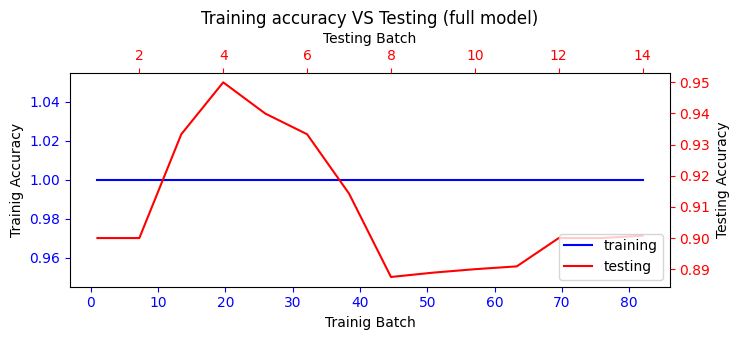

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, label="training")
ax2 = fig.add_subplot(111, label="testing", frame_on=False)
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
plt.title("Training accuracy VS Testing (full model)")

ax.plot(range(1, len(model_training_accuracy) + 1), model_training_accuracy, color="blue", label="training")
ax.set_xlabel("Trainig Batch")
ax.set_ylabel("Trainig Accuracy")
ax.tick_params(axis='x', colors="blue")
ax.tick_params(axis='y', colors="blue")

ax2.plot(range(1, len(model_testing_accuracy) + 1), model_testing_accuracy, color="red", label="testing")
ax2.set_xlabel("Testing Batch")
ax2.set_ylabel("Testing Accuracy")
ax2.xaxis.tick_top()
ax2.yaxis.tick_right()
ax2.xaxis.set_label_position('top') 
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='x', colors="red")
ax2.tick_params(axis='y', colors="red")

handles, labels = [(a + b) for a, b in zip(ax.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
plt.legend(handles, labels, loc="lower right")
plt.show()

In [ ]:
"""
Show a grid of the images, the prediction VS the expected answer
"""

'\nShow a grid of the images, the prediction VS the expected answer\n'

In [ ]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted_4.pt') # Save